This example was taken from the book **The Essence of Chaos** by *Edward Lorenz*. The aim of the model he preseted in that chapter is to show how we can construct parsimoniuos models from real case phenomenoms which exhibit chaos. 

The model consists of a board that goes down a regularly-bumpy slope or moguls without any control of the direction whatso ever. The dynamical system of this board is decribed by the system of ODE shown bellow

$$\frac{dx}{dt} = U, \quad \frac{dx}{dt} = V, \quad \frac{dz}{dt} = W.$$

\begin{align}
\frac{du}{dt} &= -F \partial_x H - cu, \\
\frac{dv}{dt} &= -F \partial_y H - cv, \\
\frac{dw}{dt} &= -g + F - cw.
\end{align}

\begin{align}
\frac{d \vec{u}}{dt} &= -F \nabla_H H - c \vec{u}.\\
\end{align}


$\vec{x} = (x,y,z)$ are the spacial coordinates and $\vec{u} = (u,v,w)$ are the components of the velocity of the board. And $H$ is the shape pf the slope that is parameterized by the following expression: 

$$H(x,y) = -ax - b \ cos(px) \ cos(qy).$$

Our first goal is to solve the ODE system for a given initial condition using numerical integration method.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We can plot the shape of the moguls to help us understand better the problem. For this we use the parameters that Lorenz suggest in his book, in which $a$ is the anlge of the slope, $b$ is the depth of the moguls, and $p$ and $q$ are the spatial frequencies of the moguls in the $x$ and $y$ directions. 

In [23]:
a = 0.25
b = 0.4
q = (2*np.pi)/4.0
p = (2*np.pi)/10.0

def H_func(x,y):
    """
        H_func(x,y)
    Function that parametrizes the moguls. 
    It takes a given x and y position as arguments, and returns 
    the height of the slope.
    """
    return -a*x - b*np.cos(p*x)*np.cos(q*y) 

def pits_n_crests(x,y):
    """
        pits_n_crests(x,y)
        
    Function that parametrizes the moguls without the slope. 
    It takes a given x and y position as arguments, and returns 
    the heights of the moguls as if they were in a flat surface.
    """
    return - b*np.cos(p*x)*np.cos(q*y) 

In [24]:
x_range = np.linspace(0, 20, 200)
y_range = np.linspace(-10, 10, 200)
XX, YY = np.meshgrid(x_range, y_range)
moguls = H_func(XX, YY)

In [25]:
from mpl_toolkits.mplot3d import Axes3D

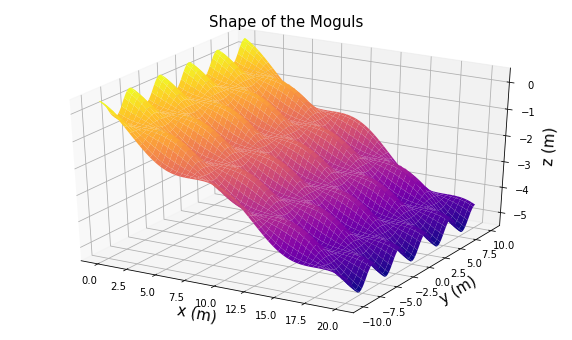

In [26]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')

ax.set_ylabel('y (m)', fontsize = 15)
ax.set_xlabel('x (m)', fontsize = 15)
ax.set_zlabel('z (m)', fontsize = 15)
ax.set_title('Shape of the Moguls', fontsize = 15)

ax.plot_surface(XX, YY, moguls, cmap = 'plasma')
plt.savefig('fig/shape_of_moguls')

**Quite cool so far!** I ❤ matplotlib.

# Boards down the slope!

In [94]:
def runge_kutta_step(f, x0, dt, t=None):
    """
        runge_kutta_step(f, x0, dt, t=None)

    Computes a step using the Runge-Kutta 4th order method.

    f is a RHS function, x0 is an array of variables to solve, 
    dt is the timestep, and t correspond to an extra paramameter of
    of the RHS.
    """

    k1 = f(t, x0) * dt
    k2 = f(t, x0 + k1/2) * dt
    k3 = f(t, x0 + k2/2) * dt
    k4 = f(t, x0 + k3) * dt
    x_new = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return x_new

def solver(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5):
    """
        solver(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5)

    Function iterate the solution using runge_kutta_step and a RHS function f, for several points or initial 
    conditions given by N.

    f is a RHS function
    x0, y0, v0, u0 are arrays containig the initial condition x,y,v,u; with N dimensions.
    dt is the timestep, 
    N_t number of time steps.
    N number of initial conditions to iterate.
    b height of the moguls, parameter fixed.
    """
    
    solution = np.zeros((4, N_t+1, N))
    solution[0,0, :] = x0
    solution[1,0, :] = y0
    solution[2,0,: ] = u0
    solution[3,0, :] = v0
    
    for i in range(1, N_t + 1):
        for k in range(N):
            
            x_0_step = solution[:, i-1, k]
            solution[:, i, k] = runge_kutta_step(f, x_0_step, dt, b)
         
    return solution

In [95]:
def board(t, X_0):
    """
        board(t, X_0)

    Right-hand-side of the equations for a board going down a slope with moguls.

    X_0 is the the set of initial conditions containing [x, y, u, v], in that oder.
    t optional parameter.
    """
    
    x0 = np.copy(X_0[0])
    y0 = np.copy(X_0[1])
    u0 = np.copy(X_0[2])
    v0 = np.copy(X_0[3])
    
    g = 9.81
    c = 0.5
    a = 0.25
    b = 0.5
    p = (2*np.pi)/10.0
    q = (2*np.pi)/4.0
    
    H = -a*x0 - b*np.cos(p*x0)*np.cos(q*y0) 
    H_x = -a + b*p*np.sin(p*x0)*np.cos(q*y0)
    H_xx = b*p**2 * np.cos(p*x0)*np.cos(q*y0)
    H_y = b*q*np.cos(p*x0)*np.sin(q*y0)
    H_yy = b*q**2 * np.cos(p*x0)*np.cos(q*y0)
    H_xy = -b*q*p*np.sin(p*x0)*np.sin(q*y0)
        
    F = (g + H_xx*u0**2 + 2*H_xy*u0*v0 + H_yy*v0**2)/(1 + H_x**2 + H_y**2)
    
    dU = -F*H_x - c*u0
    dV = -F*H_y - c*v0
    
    return np.array([u0, v0, dU, dV])

In [102]:
def plot_several(Solution):
    """
        plot_several_position(Solution)

    Function to plot several trajectories of boards or sleds. 
    Solution is the array with the solutions of the ensemble of points.
    """
    
    N = Solution.shape[2]
    plt.figure(figsize=(5,10))
    
    for i in range(0,N):
        plt.plot(Solution[1, :, i], Solution[0, :, i])

    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid()
    plt.ylabel('x - Downslope position (m)', fontsize =13)
    plt.xlabel('y - Crossslope position (m)', fontsize =13)

So now that we have our solver we can crush some snow with our boards in the moguls! 

### Example 1

Initial conditions: $x = 0.0$, $y = [0,1]$ (randomly chosen), $U = 3.5$ and $V = 0$.

Text(0.5, 1.0, '10 boards')

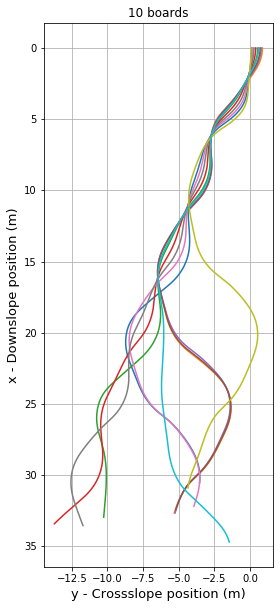

In [84]:
n_sleds = 10
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.random.rand(n_sleds)
v_init = np.zeros(n_sleds)
u_init = np.zeros(n_sleds) + 3.5

sol_ex1 = solver(board, x_init, y_init, v_init, u_init , 0.01, n_time, n_sleds)

plot_several(sol_ex1)
plt.title('10 boards')

### Example 2

Initial conditions: $x = 0.0$, $y = [0,1]$ scattered evenly, $U = 4.0$ and $V = 2.0$.

Text(0.5, 1.0, '1 cm between boards')

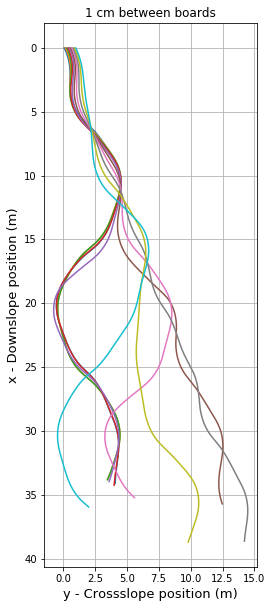

In [82]:
n_sleds = 10
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.linspace(0.1, 1, n_sleds)
v_init = np.zeros(n_sleds) + 2
u_init = np.zeros(n_sleds) + 4

sol_ex2 = solver(board, x_init, y_init, v_init, u_init , 0.01, n_time, n_sleds)

plot_several(sol_ex2)
plt.title('1 cm between boards')

We can see how the system behaves chaotically, i.e if we vary a little the initial conditions, the trajectories of the boards diverge after 10 m downslope.

### Example 3
Initial conditions just spaced $1$mm apart from $0.497$m to $0.503$m.

Text(0.5, 1.0, '1 mm between boards')

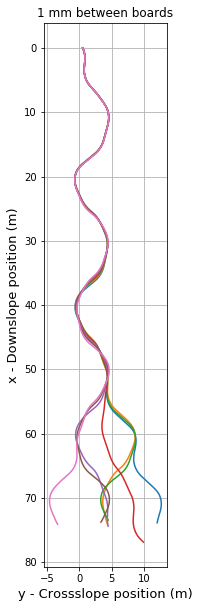

In [83]:
n_sleds = 7
n_time = 2200
x_init = np.zeros(n_sleds)
y_init = np.linspace(0.497, 0.503, n_sleds)
v_init = np.zeros(n_sleds) + 2
u_init = np.zeros(n_sleds) + 4

sol_ex3 = solver(board, x_init, y_init, v_init, u_init , 0.01, n_time, n_sleds)

plot_several(sol_ex3)
plt.title('1 mm between boards')

The above shows that the system is sensitive to initial conditions but we would like to explore further the dynamics of the system. One of the technique for exploring the dynamics of the system is by plotting the phase space and see how the system behaves. The only problem is that for this system, there are 4 variables, which means that the phase space of the system lives in a four-dimensional space, which is not possible for us to visualize. We need to do some modifications to our board to reduce the dimensions of our system.


# Sleds down the slope!

To reduce the dimensions of our system, we can make the downslope velocity to be constants, or in the real world, by equipping our board with some brakes and an engine so it can maintain a constant velocity while going down the pits or up the bumps. In a mathematical sense, we say that $\partial_t U = 0$.

In [101]:
def sled(t, X_0):
    """
        sled(t, X_0)

    Right-hand-side of the equations for a sled, with constant downward velocity, 
    going down a slope with moguls.

    X_0 is the the set of initial conditions containing [x, y, u, v], in that oder.
    t optional parameter.
    """

    x0 = np.copy(X_0[0])
    y0 = np.copy(X_0[1])
    u0 = np.copy(X_0[2])
    v0 = np.copy(X_0[3])
    
    g = 9.81
    c = 0.5
    a = 0.25
    #b = 0.5
    p = (2*np.pi)/10.0
    q = (2*np.pi)/4.0
    
    H = -a*x0 - b*np.cos(p*x0)*np.cos(q*y0) 
    H_x = -a + b*p*np.sin(p*x0)*np.cos(q*y0)
    H_xx = b*p**2 * np.cos(p*x0)*np.cos(q*y0)
    H_y = b*q*np.cos(p*x0)*np.sin(q*y0)
    H_yy = b*q**2 * np.cos(p*x0)*np.cos(q*y0)
    H_xy = -b*q*p*np.sin(p*x0)*np.sin(q*y0)
        
    F = (g + H_xx*u0**2 + 2*H_xy*u0*v0 + H_yy*v0**2)/(1 + H_x**2 + H_y**2)
    
    dU = 0
    dV = -F*H_y - c*v0
    
    return np.array([u0, v0, dU, dV])

Text(0.5, 1.0, '10 sleds down the slope')

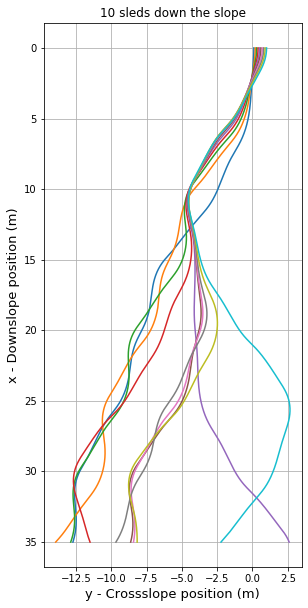

In [86]:
n_sleds = 10
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.linspace(0.1, 1, n_sleds)
v_init = np.zeros(n_sleds)
u_init = np.zeros(n_sleds) + 3.5

sled_ex1 = solver(sled, x_init, y_init, v_init, u_init , 0.01, n_time, n_sleds)

plot_several(sled_ex1)
plt.title('10 sleds down the slope')

The previous system is not compact, i.e., $X$ and $Y$ can grow infinitidly. 

# Sleds and strange attractors

Now our system has 3 variables, which will allow us to plot it phase space. The only problem now is that the system is no compact, because $x$ and $y$ can grow or decrease infinitively. Although, the cross slope velocity $v$ is bounded between $-5$ m/s and $5$ m/s, because of friction.

A way to do this is reducing the slope to be $x \in [-5, 5]$ m and $y \in [-2, 2]$ m, and set the boundaries to be periodic. This way, we will be able to compact the position of the sled without altering the physics of the system. 

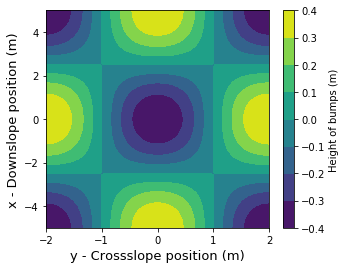

In [10]:
x_range_compact = np.linspace(-5, 5, 50)
y_range_compact = np.linspace(-2, 2, 50)
XX_c, YY_c = np.meshgrid(x_range_compact, y_range_compact)

moguls_compact = pits_n_crests(XX_c, YY_c)

plt.figure(figsize=(5,4))
plt.contourf(YY_c, XX_c, moguls_compact)
plt.colorbar(label = 'Height of bumps (m)')
plt.ylabel('x - Downslope position (m)', fontsize =13)
plt.xlabel('y - Crossslope position (m)', fontsize =13)
plt.savefig('fig/shape_of_moguls_compact')

In [98]:
def compactor(x, lower_bound, upper_bound):
    """
        compactor(x, lower_bound, upper_bound)

    Funtion that maps any point outside the interval [lower_bound, upper_bound] 
    to a point in the interval, preserving length. If the point is in the interval,
    it does not change.

    x point in question to be evaluated.
    lower_bound lower bound of the interval.
    upper_bound upper bound of the interval.
    """
    
    if x > upper_bound: 
        return x%upper_bound - upper_bound
    elif x < lower_bound: 
        return x%lower_bound - lower_bound
    else: 
        return x

In [100]:
def solver_compact(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5):
    """
        solver_compact(f, x0, y0, v0, u0, dt, N_t, N, b = 0.5)

    Function iterate the solution using runge_kutta_step and a RHS function f, for several points or initial 
    conditions given by N, in compact domain. 

    f is a RHS function
    x0, y0, v0, u0 are arrays containig the initial condition x,y,v,u; with N dimensions.
    dt is the timestep, 
    N_t number of time steps.
    N number of initial conditions to iterate.
    b height of the moguls, parameter fixed.
    """
    
    solution = np.zeros((3, N_t+1, N))
    solution[0,0, :] = x0
    solution[1,0, :] = y0
    solution[2,0, :] = v0
    
    for i in range(1, N_t + 1):
        for k in range(N):
            
            x_0_step = np.insert(solution[:, i-1, k], 2, u0)
            
            aux = runge_kutta_step(f, x_0_step, dt, b)
            solution[0, i, k] = compactor(aux[0], -5, 5)
            solution[1, i, k] = compactor(aux[1], -2, 2)
            solution[2, i, k] = aux[3]
            
    return solution

Text(0.5, 1.0, '1 sled in compact domain')

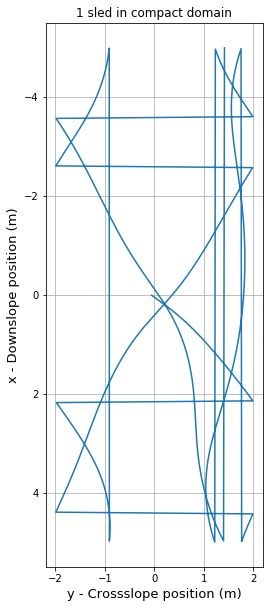

In [89]:
n_sleds = 1
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.random.rand(n_sleds)*4 - 2
v_init = np.random.rand(n_sleds)*10 - 5

sled_compact_1 = solver_compact(sled, x_init, y_init, v_init, 3.5, 0.01, n_time, n_sleds)
plot_several(sled_compact_1)

plt.title('1 sled in compact domain')

In [90]:
import time

In [92]:
n_sleds = 1000
n_time = 1000
x_init = np.zeros(n_sleds)
y_init = np.random.rand(n_sleds)*4 - 2
v_init = np.random.rand(n_sleds)*10 - 5

start = time.time()
sled_compact_1000 = solver_compact(sled, x_init, y_init, v_init, 3.5, 0.01, n_time, n_sleds)
end = time.time()
print("Elapsed time:", (end - start)/60, "minutes...")

Elapsed time: 5.444671448071798 minutes...


> Here is when I realized how bad I am in making my code to go fast... 

Text(-0.01, 0.5, 'v - Cross slope velocity (m/s)')

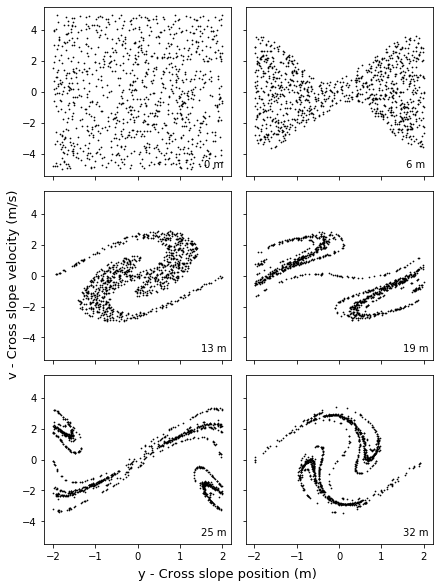

In [21]:
time_steps = range(0,1000, 180)

fig, axes = plt.subplots(3, 2, sharex=True, sharey= True, figsize = (6,8))
axes = axes.reshape(6)

for i, j in enumerate(time_steps):
    
    dist = round(j*(3.5*0.01))
    axes[i].scatter(sled_compact_1000[1, j, :], sled_compact_1000[2, j, :], s = 0.5, color = 'k')
    axes[i].text(1.8,-4.9, '{} m'.format(dist) , ha='center')
    
plt.tight_layout()
fig.text(0.5, -0.01, 'y - Cross slope position (m)', ha='center', fontsize = 13)
fig.text(-0.01, 0.5, 'v - Cross slope velocity (m/s)', va='center', rotation='vertical', fontsize = 13)

